In [186]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [187]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [188]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [189]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [190]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X_train = train_data['data']
Y_train = train_data['target']
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))


X_test = test_data['data']

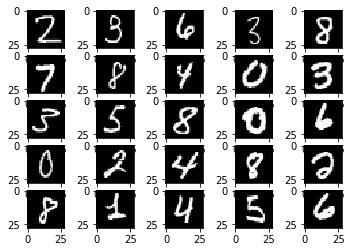

In [191]:
n=5
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

# Layers


Я использовал немного другую концепцию реализации слоёв. Я их сделал функциями. Forward pass возвращает своё возвращаемое значение и кэш, который затем передаётся в backward pass. За исключением "softmaxPlusLoss".


My softmax and loss function in one. All in one, perfect!

In [192]:
def softmaxPlusLoss(rawScores, correctScores):
    loss = 0
    numClasses = rawScores.shape[0]
    scores = rawScores - np.max(rawScores, axis=1, keepdims=True)
    normalizeCoefs = np.sum(np.exp(scores), axis=1, keepdims=True)
    logNormalizeScores = scores - np.log(normalizeCoefs)
    normalizeScores = np.exp(logNormalizeScores)
    loss = -np.sum(logNormalizeScores[np.arange(numClasses), correctScores]) /  numClasses
    grad = normalizeScores.copy()
    grad[np.arange(numClasses), correctScores] -= 1
    grad /= numClasses
    return loss, grad


# Affine Layer, forward & backward

In [193]:
def affineForward(x, w, b):
    out = None
    D = w.shape[0]
    N = x.shape[0]
    out = np.dot(np.reshape(np.ravel(x), (N, D)), w) + b
    cache = (x, w, b)
    return out, cache

def affineBackward(dout, cache):
    x, w, b = cache
    dx, dw, db = None, None, None
    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], w.shape[0]).T.dot(dout)
    db = np.sum(dout, axis=0)
    return dx, dw, db

# ReLu Layer

In [194]:
def reluForward(x):
    out = None
    out = np.maximum(0, x)
    cache = x
    return out, cache


def reluBackward(dout, cache):
    dx, x = None, cache
    dx = np.maximum(0, x)
    dx[x > 0] = 1
    dx *= dout
    return dx

def leakyReluForward(x):
    out = None
    out = np.where(x > 0, x, x * 0.01)
    cache = x
    return out, cache


def leakyReluBackward(dout, cache):
    dx, x = None, cache
    dx = np.where(x > 0, 1, 0.01)
    dx *= dout
    return dx

# Dropout



In [195]:
def dropoutForward(x, mode = "train"):
    p = 0.5
    mask = None
    out = None
    if mode == 'train':
        mask = np.random.binomial(1, 1 - p, size = x.shape) / (1 - p)
        out = x * mask
    elif mode == 'test':
        out = x
    cache = (mode, mask)
    out = out.astype(x.dtype, copy=False)
    return out, cache


def dropoutBackward(dout, cache):
    mode, mask = cache
    dx = None
    if mode == 'train':
        dx = dout * mask
    elif mode == 'test':
        dx = dout
    return dx

# Affine-ReLu Layer

In [196]:
def affineReluForward(x, w, b, dropout_mode):
    a, affineCache = affineForward(x, w, b)
    out, reluCache = leakyReluForward(a)
    out, dropoutCache = dropoutForward(out, dropout_mode)
    cache = (affineCache, reluCache, dropoutCache)
    return out, cache


def affineReluBackward(dout, cache):
    affineCache, reluCache, dropoutCache = cache
    da = dropoutBackward(dout, dropoutCache)
    da = leakyReluBackward(dout, reluCache)
    dx, dw, db = affineBackward(da, affineCache)
    return dx, dw, db


# State-of-the-Art update rule - Adam


In [197]:
def adam(w, dw, config=None):
    if config is None: config = {}
    config.setdefault('learningRate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('t', 0)

    next_w = None
    
    t = config['t'] + 1
    m = config['beta1'] * config['m'] + (1 - config['beta1']) * dw
    mt = m / (1 - config['beta1']**t)
    v = config['beta2'] * config['v'] + (1 - config['beta2']) * (dw**2)
    vt = v / (1 - config['beta2']**t)
    next_w = w - config['learningRate'] * mt / (np.sqrt(vt) + config['epsilon'])
    config['t'] = t
    config['m'] = m
    config['v'] = v

    return next_w, config


def sgd(w, dw, learningRate):
    return w - learningRate * dw



# MultiLayers Network

In [198]:
class TwoLayersNet(object):

    def __init__(self, inputDim, hiddenDim, numClasses,
                 weightScale=1e-3, reg=0.0):
        self.params = {}
        self.bestParams = {}
        self.reg = reg
        self.params['W1'] = weight_scale * np.random.randn(inputDim, hiddenDim)
        self.params['b1'] = np.zeros(hiddenDim)
        self.params['W2'] = weightScale * np.random.randn(hiddenDim, numClasses)
        self.params['b2'] = np.zeros(numClasses)
        self.bestParams['W1'] = weightScale * np.random.randn(inputDim, hiddenDim)
        self.bestParams['b1'] = np.zeros(hiddenDim)
        self.bestParams['W2'] = weightScale * np.random.randn(hiddenDim, numClasses)
        self.bestParams['b2'] = np.zeros(numClasses)
        self.bestValAcc = 0

        
    def train(self, data, learningRate=1e-7, numIters=10000, batchSize=200, verbose=True):
        trainData = data["trainData"]
        trainLabels = data["trainLabels"]
        valData = data["valData"]
        valLabels = data["valLabels"]
        reg = self.reg
        
        optimConfig = {}
        for weightsName in self.params.keys():
            optimConfig.update({weightsName : {"learningRate" : learningRate}})
        
        numTrain, vectorSize = trainData.shape
        numClasses = np.max(trainLabels) + 1

        lossHistoryTrain = {}
        lossHistoryVal = {}
        accHistoryTrain = {}
        accHistoryVal = {} 
        for it in range(numIters):
            batchIndicies = np.random.choice(numTrain, batchSize)
            X_batch = trainData[batchIndicies]
            y_batch = trainLabels[batchIndicies]
            trainLoss, grads = self.step(X_batch, y_batch)
            lossHistoryTrain[it] = trainLoss
            
            for weightsName in self.params.keys():
                self.params[weightsName], optimConfig[weightsName] = adam(self.params[weightsName], grads[weightsName], optimConfig[weightsName])
                
            if verbose and it % (numIters/ 20) == 0:
                valLoss, _ = self.step(valData, valLabels)
                lossHistoryVal[it] = valLoss
                trainAcc = self.accuracy(X_batch, y_batch)
                valAcc = self.accuracy(valData, valLabels)
                accHistoryTrain[it] = trainAcc
                accHistoryVal[it] = valAcc
                print('iteration %d / %d: train loss %f val loss %f train acc - %f val acc - %f' % (it, numIters, trainLoss, valLoss, trainAcc, valAcc))
                
                
                if (valAcc > self.bestValAcc):
                    self.bestParams['W1'] = np.copy(self.params['W1'])
                    self.bestParams['b1'] = np.copy(self.params['b1'])
                    self.bestParams['W2'] = np.copy(self.params['W2'])
                    self.bestParams['b2'] = np.copy(self.params['b2'])
                    self.bestValAcc = valAcc 
                    print("new best Acc -", valAcc)
                    
                for key in optimConfig.keys():
                    optimConfig[key]["learningRate"] *= 0.85
                
        return lossHistoryTrain, lossHistoryVal, accHistoryTrain, accHistoryVal
                

    def step(self, X, y=None):
        loss, cache = self._forward(X, y)
        grads = self._backward(y, cache)
        return loss, grads

    #just calculate scores and cache, no loss (with aim to code func "predict" easier)
    def net(self, X, dropout_mode):
        scores = None
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        intermediateOut, cache1 = affineReluForward(X, W1, b1, dropout_mode)
        scores, cache2 = affineForward(intermediateOut, W2, b2)
        return scores, cache1, cache2
    
    def bestNet(self, X):
        scores = None
        W1, b1 = self.bestParams['W1'], self.bestParams['b1']
        W2, b2 = self.bestParams['W2'], self.bestParams['b2']
        intermediateOut, _ = affineReluForward(X, W1, b1, "test")
        scores, _ = affineForward(intermediateOut, W2, b2)
        return scores
    
    #full forward pass with loss business
    def _forward(self, X, y):
        scores, cache1, cache2 = self.net(X, "train")
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        loss, dout = softmaxPlusLoss(scores, y)
        loss += 0.5 * self.reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
        cache = (dout, cache1, cache2)
        return loss, cache
    
    #full backward pass
    def _backward(self, y, cache):
        dout, cache1, cache2 = cache
        grads = {}
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        dx1, grads['W2'], grads['b2'] = affineBackward(dout, cache2)
        dx2, grads['W1'], grads['b1'] = affineReluBackward(dx1, cache1)
        grads['W1'] += self.reg * W1
        grads['W2'] += self.reg * W2
        return grads
        
    
    def predict(self, data):
        scores, _, _ = self.net(data, "test")
        y_pred = [np.argmax(x) for x in scores]
        return y_pred
    
    def accuracy(self, data, labels):
        return (self.predict(data) == labels).mean()
        

In [199]:
# Data Preparing
data = {}
trainPercentage = 0.85
lenFull = len(X_train)
lenTrain = round(lenFull * trainPercentage)
lenVal = lenFull - lenTrain

Y_train = np.array([int(x) for x in Y_train])

trainIndicies = np.random.choice(lenTrain, lenTrain)
data["trainData"] = X_train[trainIndicies]
data["trainLabels"] = Y_train[trainIndicies]
valIndicies = np.random.choice(lenVal, lenVal) + lenTrain
data["valData"] = X_train[valIndicies]
data["valLabels"] = Y_train[valIndicies]

In [ ]:
inputDim=28*28
hiddenDim=470
numClasses=10
weightScale=1e-2


reg = 9e-3
learningRate = 1e-3
numIters= 10000


model = TwoLayersNet(input_dim, hidden_dim, num_classes, weight_scale, reg)
lossHistoryTrain, lossHistoryVal, accHistoryTrain, accHistoryVal = model.train(data, learningRate, numIters)

iteration 0 / 10000: train loss 11.305049 val loss 16.116259 train acc - 0.420000 val acc - 0.349460
new best Acc - 0.34946031746031747


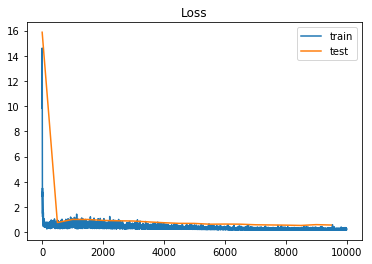

In [201]:
plt.title('Loss')
plt.plot(lossHistoryTrain.keys(), lossHistoryTrain.values(), label='train')
plt.plot(lossHistoryVal.keys(), lossHistoryVal.values(), label='test')
plt.legend()

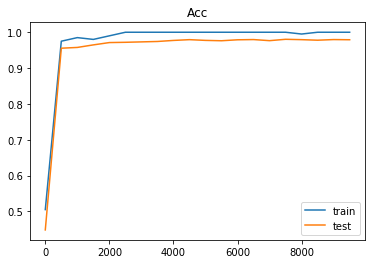

In [202]:
plt.title('Acc')
plt.plot(accHistoryTrain.keys(), accHistoryTrain.values(), label='train')
plt.plot(accHistoryVal.keys(), accHistoryVal.values(), label='test')
plt.legend()

In [203]:
fname="a_submission.csv"
with open(fname,'w') as fout:
    fout.write('Id,Category')
    scores = model.bestNet(X_test)
    for i in range(len(scores)):
        y = np.argmax(scores[i])
        fout.write("\n{},{}".format(i, int(y)))